In [28]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression

from sklearn.metrics import mean_squared_error

In [2]:
df = pd.read_parquet("https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2024-01.parquet")

## Data preprocessing

In [3]:
df.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,Airport_fee
0,2,2024-01-01 00:57:55,2024-01-01 01:17:43,1.0,1.72,1.0,N,186,79,2,17.7,1.0,0.5,0.00,0.0,1.0,22.70,2.5,0.0
1,1,2024-01-01 00:03:00,2024-01-01 00:09:36,1.0,1.80,1.0,N,140,236,1,10.0,3.5,0.5,3.75,0.0,1.0,18.75,2.5,0.0
2,1,2024-01-01 00:17:06,2024-01-01 00:35:01,1.0,4.70,1.0,N,236,79,1,23.3,3.5,0.5,3.00,0.0,1.0,31.30,2.5,0.0
3,1,2024-01-01 00:36:38,2024-01-01 00:44:56,1.0,1.40,1.0,N,79,211,1,10.0,3.5,0.5,2.00,0.0,1.0,17.00,2.5,0.0
4,1,2024-01-01 00:46:51,2024-01-01 00:52:57,1.0,0.80,1.0,N,211,148,1,7.9,3.5,0.5,3.20,0.0,1.0,16.10,2.5,0.0


In [4]:
df.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,Airport_fee
0,2,2024-01-01 00:57:55,2024-01-01 01:17:43,1.0,1.72,1.0,N,186,79,2,17.7,1.0,0.5,0.00,0.0,1.0,22.70,2.5,0.0
1,1,2024-01-01 00:03:00,2024-01-01 00:09:36,1.0,1.80,1.0,N,140,236,1,10.0,3.5,0.5,3.75,0.0,1.0,18.75,2.5,0.0
2,1,2024-01-01 00:17:06,2024-01-01 00:35:01,1.0,4.70,1.0,N,236,79,1,23.3,3.5,0.5,3.00,0.0,1.0,31.30,2.5,0.0
3,1,2024-01-01 00:36:38,2024-01-01 00:44:56,1.0,1.40,1.0,N,79,211,1,10.0,3.5,0.5,2.00,0.0,1.0,17.00,2.5,0.0
4,1,2024-01-01 00:46:51,2024-01-01 00:52:57,1.0,0.80,1.0,N,211,148,1,7.9,3.5,0.5,3.20,0.0,1.0,16.10,2.5,0.0


Compute the trip duration in minutes

In [5]:
df["duration"] = df.tpep_dropoff_datetime - df.tpep_pickup_datetime
import time
t_start = time.time()
df["duration"] = df.duration.apply(lambda dt: dt.total_seconds()/60)
print(time.time()-t_start)

6.743443489074707


In [6]:
df.duration.describe()

count    2.964624e+06
mean     1.561295e+01
std      3.485105e+01
min     -1.356667e+01
25%      7.150000e+00
50%      1.163333e+01
75%      1.868333e+01
max      9.455400e+03
Name: duration, dtype: float64

In [7]:
# There are trips with negative duration (min <0), probably errors
# Remove trips with negative duration
df = df[df["duration"]>0.0]

In [8]:
df.duration.describe(percentiles = [0.95,0.98,0.99])

count    2.963754e+06
mean     1.561756e+01
std      3.485513e+01
min      1.666667e-02
50%      1.163333e+01
95%      3.795000e+01
98%      5.100000e+01
99%      6.045000e+01
max      9.455400e+03
Name: duration, dtype: float64

Note: 99% of the duration are within 1 hour. 
We are going to filter trips to be at least 1 min and max 1 hour long

In [9]:
df_filtered = df[((df.duration >=1) & (df.duration <=61))].copy()

## Features selection

In [10]:
df_filtered.columns

Index(['VendorID', 'tpep_pickup_datetime', 'tpep_dropoff_datetime',
       'passenger_count', 'trip_distance', 'RatecodeID', 'store_and_fwd_flag',
       'PULocationID', 'DOLocationID', 'payment_type', 'fare_amount', 'extra',
       'mta_tax', 'tip_amount', 'tolls_amount', 'improvement_surcharge',
       'total_amount', 'congestion_surcharge', 'Airport_fee', 'duration'],
      dtype='object')

In [11]:
categorical = ['PULocationID','DOLocationID']
numerical = ['trip_distance']
# NOTE: also the time of pickup could be interesting as rush-hours or holidays might influence the trip time

In [12]:
df_filtered[categorical].dtypes

PULocationID    int32
DOLocationID    int32
dtype: object

In [13]:
# Use one-hot-encoding. To use the dictionary vectorizer, we need to change the dtype to str otherwise it 
# won't do the encoding

In [14]:
df_filtered[categorical]= df_filtered[categorical].astype(str)

In [15]:
train_dict = df_filtered[categorical + numerical].to_dict(orient='records') 

In [16]:
dv = DictVectorizer()
X_train = dv.fit_transform(train_dict)

In [21]:
target= 'trip_distance'
y_train = df_filtered[target].values

## Trai a linear regression model

In [25]:
lr = LinearRegression()
lr.fit(X_train, y_train)

,"fit_intercept fit_intercept: bool, default=TrueWhether to calculate the intercept for this model. If setto False, no intercept will be used in calculations(i.e. data is expected to be centered).",True
,"copy_X copy_X: bool, default=TrueIf True, X will be copied; else, it may be overwritten.",True
,"tol tol: float, default=1e-6The precision of the solution (`coef_`) is determined by `tol` whichspecifies a different convergence criterion for the `lsqr` solver.`tol` is set as `atol` and `btol` of :func:`scipy.sparse.linalg.lsqr` whenfitting on sparse training data. This parameter has no effect when fittingon dense data... versionadded:: 1.7",1e-06
,"n_jobs n_jobs: int, default=NoneThe number of jobs to use for the computation. This will only providespeedup in case of sufficiently large problems, that is if firstly`n_targets > 1` and secondly `X` is sparse or if `positive` is setto `True`. ``None`` means 1 unless in a:obj:`joblib.parallel_backend` context. ``-1`` means using allprocessors. See :term:`Glossary ` for more details.",None
,"positive positive: bool, default=FalseWhen set to ``True``, forces the coefficients to be positive. Thisoption is only supported for dense arrays.For a comparison between a linear regression model with positive constraintson the regression coefficients and a linear regression without such constraints,see :ref:`sphx_glr_auto_examples_linear_model_plot_nnls.py`... versionadded:: 0.24",False


In [26]:
y_pred = lr.predict(X_train)

In [31]:
y_train

array([1.72, 1.8 , 4.7 , ..., 3.33, 3.06, 8.1 ], shape=(2901082,))

In [30]:
y_pred

array([1.71999898, 1.79999892, 4.69999834, ..., 3.3300005 , 3.06000051,
       8.10000357], shape=(2901082,))

/tmp/ipykernel_46023/2311638271.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_pred, label='prediction')
/tmp/ipykernel_46023/2311638271.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_train, label='training')


<Axes: ylabel='Density'>

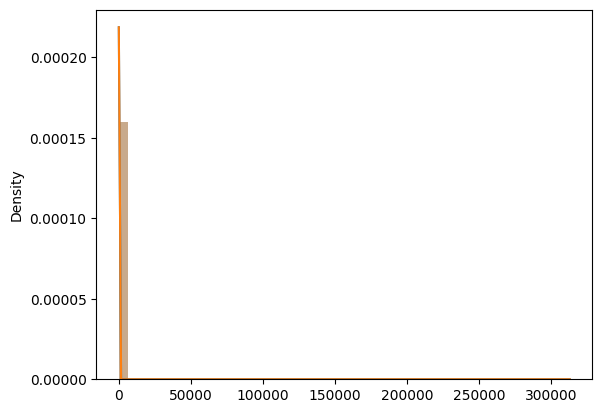

In [32]:
sns.distplot(y_pred, label='prediction')
sns.distplot(y_train, label='training')

In [ ]:
https://youtu.be/iRunifGSHFc?list=PL3MmuxUbc_hIUISrluw_A7wDSmfOhErJK&t=1305